# 2. Exploratory Data Analysis<a id='2_EDA'></a>

## Data Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_csv("Data//data.csv")

#_________ Data manipulation in data wrangling part
# Function to clean column names
def clean_column_names(col):
    col = col.replace(' (times)', '') # Remove ' (times)'
    col = col.replace(' (Yuan ¥)', '') # Remove ' (Yuan ??)'
    col = col.replace('?', '')  # Remove question marks
    col = col.strip()  # Remove leading and trailing spaces
    col = col.replace(' ', '_')  # Replace spaces with underscores
    col = col.replace('%', 'pct')  # Replace % with 'percent'
    col = col.replace('/', '_to_')  # Replace / with '_to_'
    col = col.replace('(', '')  # Remove opening parentheses
    col = col.replace(')', '')  # Remove closing parentheses
    col = re.sub(r'_([a-z])', lambda x: '_' + x.group(1).upper(), col) # Convert first letter after underscore to uppercase
    return col

# Apply the function to all column names
df.columns = [clean_column_names(col) for col in df.columns]

# Convert binary variables to categorical
binary_columns = ['Bankrupt', 'Net_Income_Flag', 'Liability-Assets_Flag']
df[binary_columns] = df[binary_columns].astype('category')

df.drop(columns = 'Net_Income_Flag', inplace=True)


## 2.1 Univariate Analysis <a id='2.1_Univariate_Analysis'></a>

In the data wrangling section, we learned that some of the numerical features contain numerous outliers and have a skewed distribution. This can be a potential problem when we build models. In such cases, we can consider transforming the data using methods like log transformation and other outlier detection methods, such as Z-scoring, as remedies to these problems.

### 2.1.1 Log Transformation on Numeric Features <a id='2.1.1_Log_Transformation_on_Numeric_Features'></a>
<br>
Since the minimum value of most features is 0, you can try adding a small constant to all values before applying a log transformation. For example, applying log(x + 1) when the minimum value is 0 can help avoid issues with negative values.

In [3]:
# fn for log transformation
def log_transform(df):
    # selecting numeric features
    numeric_features = df.select_dtypes(include=[np.number])
    
    # log transformation
    log_transformed = numeric_features.map(lambda x: np.log(x + 1) if x >= 0 else np.nan)
    
    # putting transformed data into original df
    df[numeric_features.columns] = log_transformed
    
    return df

df_log = log_transform(df)
df_log.head()

Bankrupt  ROAC_Before_Interest_And_Depreciation_Before_Interest  \
0        1                                           0.315244       
1        1                                           0.381371       
2        1                                           0.354923       
3        1                                           0.336361       
4        1                                           0.381870       

   ROAA_Before_Interest_And_Pct_After_Tax  \
0                                0.353743   
1                                0.430622   
2                                0.404811   
3                                0.372435   
4                                0.430764   

   ROAB_Before_Interest_And_Depreciation_After_Tax  Operating_Gross_Margin  \
0                                         0.340571                0.470914   
1                                         0.416557                0.476380   
2                                         0.386822                0.470909   
3                                         0.376883                0.459664   
4                                         0.420221                0.469243   

   Realized_Sales_Gross_Margin  Operating_Profit_Rate  \
0                     0.470914               0.692632   
1                     0.476380               0.692620   
2                     0.470855               0.692576   
3                     0.459664               0.692497   
4                     0.469243               0.692634   

   Pre-tax_Net_Interest_Rate  After-tax_Net_Interest_Rate  \
0                   0.586056                     0.592669   
1                   0.586330                     0.592940   
2                   0.585787                     0.592436   
3                   0.586100                     0.592755   
4                   0.586322                     0.592942   

   Non-industry_Income_And_Expenditure_To_Revenue  ...  Liability-Assets_Flag  \
0                                        0.264398  ...                      0   
1                                        0.265096  ...                      0   
2                                        0.263929  ...                      0   
3                                        0.264938  ...                      0   
4                                        0.265034  ...                      0   

   Net_Income_To_Total_Assets  Total_Assets_To_GNP_Price  No-credit_Interval  \
0                    0.540489                   0.009177            0.484202   
1                    0.585171                   0.008289            0.484678   
2                    0.573614                   0.039223            0.484794   
3                    0.553629                   0.003247            0.484232   
4                    0.585014                   0.003870            0.484597   

   Gross_Profit_To_Sales  Net_Income_To_Stockholder's_Equity  \
0               0.470912                            0.603162   
1               0.476381                            0.609749   
2               0.470909                            0.608011   
3               0.459661                            0.606879   
4               0.469242                            0.609751   

   Liability_To_Equity  Degree_Of_Financial_Leverage_DFL  \
0             0.254799                          0.026253   
1             0.249860                          0.234738   
2             0.254788                          0.026208   
3             0.248204                          0.026346   
4             0.245698                          0.024450   

   Interest_Coverage_Ratio_Interest_Expense_To_EBIT  Equity_To_Liability  
0                                          0.447279             0.016335  
1                                          0.451187             0.020581  
2                                          0.447059             0.016340  
3                                          0.447671             0.023699  
4                                          0.454

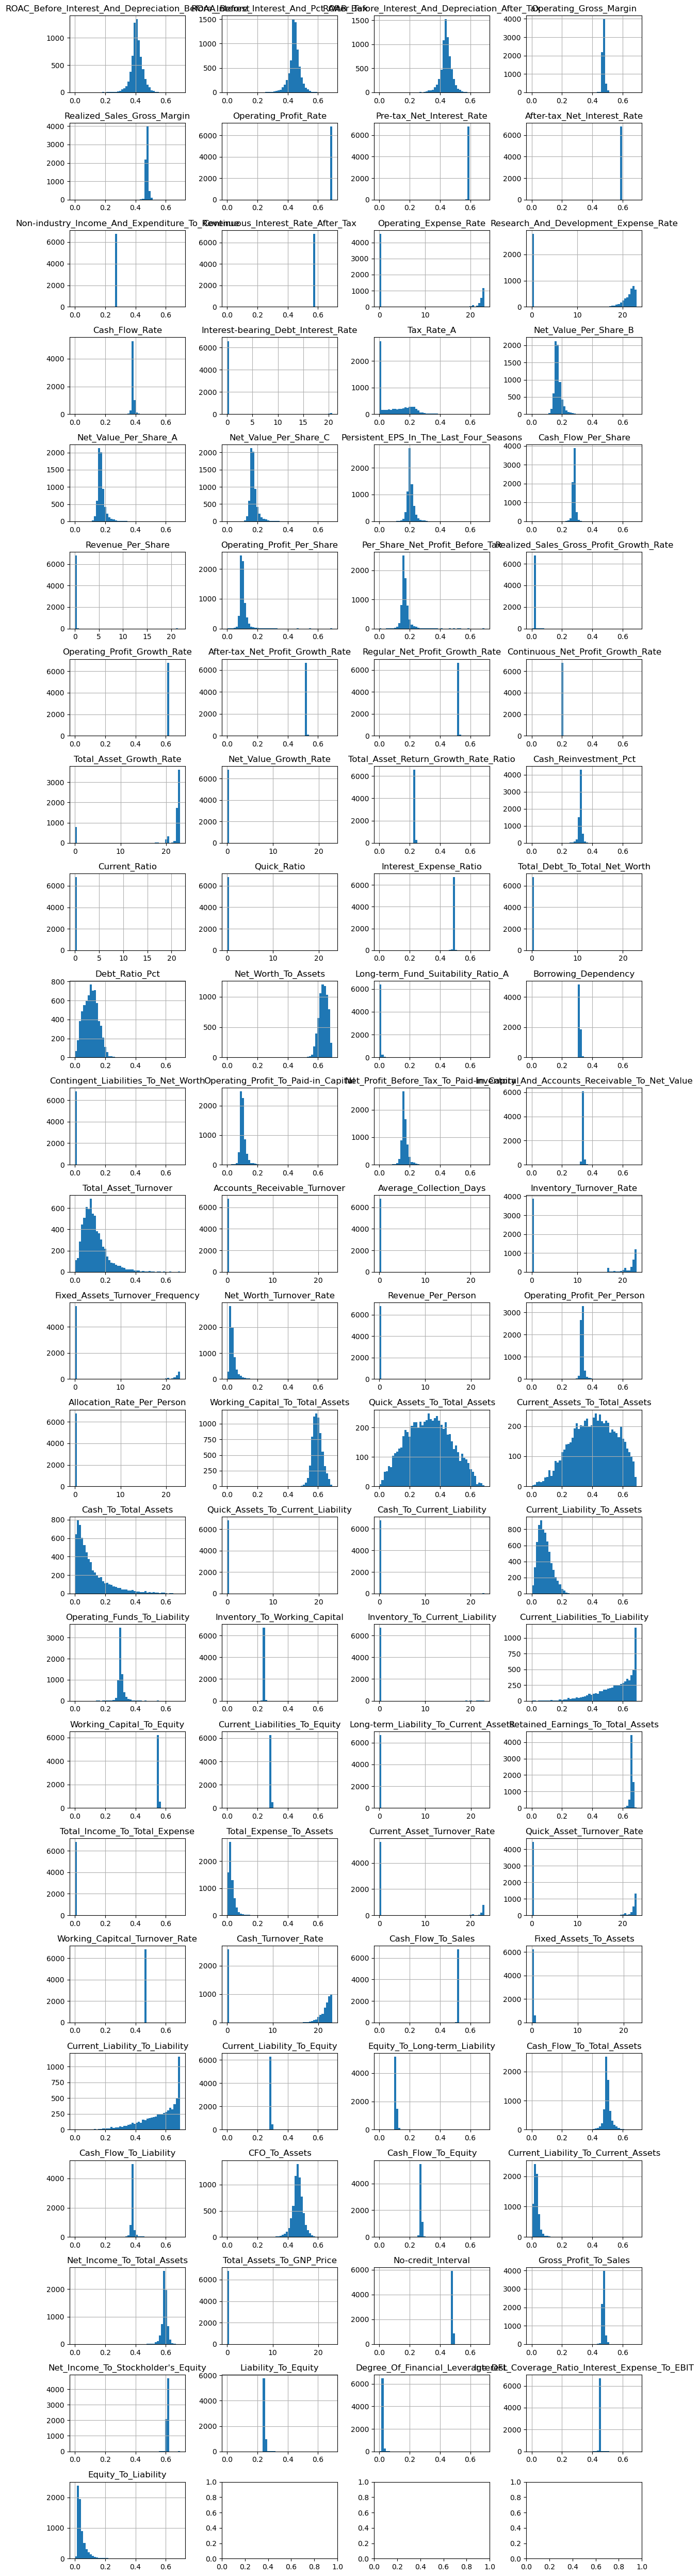

In [4]:
df_log_numeric = df_log.select_dtypes(include=[np.number])

# Create the figure and axes
fig, axes = plt.subplots(nrows=24, ncols=4, figsize=(12, 50))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each variable's histogram
for i, col in enumerate(df_log_numeric.columns):
    df_log_numeric[col].hist(ax=axes[i], bins=50)
    axes[i].set_title(col)

# Adjust layout
plt.tight_layout()

plt.show()


The distributions of the features do not appear to be significantly improved compared to raw data. Therefore, we have decided not to apply the log transformation.

### 2.1.2 Detecting Outliers using Z-Scoring <a id='2.1.1_Log_Transformation_on_Numeric_Features'></a>
<br>

As observed in the data wrangling section, using the interquartile range with a multiplier of 3 results in too many data points being identified as outliers. Therefore, we will use an alternative method, Z-scoring, in this case.

In [5]:
# fn to replace outliers with NA using Z-Scoring

def replace_outliers_with_na(data, threshold=2):
    # Numeric features only
    numeric_cols = data.select_dtypes(include=[np.number]).columns

    # Apply Z-scoring
    z_scores = data[numeric_cols].apply(zscore)

    # Replace values with NA where abs(z-score) > threshold
    data[numeric_cols] = data[numeric_cols].mask(z_scores.abs() > threshold, np.nan)

    return df

In [6]:
df_nonoutlier = replace_outliers_with_na(df, threshold=3)
df_nonoutlier.head()

Bankrupt  ROAC_Before_Interest_And_Depreciation_Before_Interest  \
0        1                                           0.315244       
1        1                                           0.381371       
2        1                                           0.354923       
3        1                                           0.336361       
4        1                                           0.381870       

   ROAA_Before_Interest_And_Pct_After_Tax  \
0                                0.353743   
1                                0.430622   
2                                0.404811   
3                                0.372435   
4                                0.430764   

   ROAB_Before_Interest_And_Depreciation_After_Tax  Operating_Gross_Margin  \
0                                         0.340571                0.470914   
1                                         0.416557                0.476380   
2                                         0.386822                0.470909   
3                                         0.376883                0.459664   
4                                         0.420221                0.469243   

   Realized_Sales_Gross_Margin  Operating_Profit_Rate  \
0                     0.470914               0.692632   
1                     0.476380               0.692620   
2                     0.470855               0.692576   
3                     0.459664               0.692497   
4                     0.469243               0.692634   

   Pre-tax_Net_Interest_Rate  After-tax_Net_Interest_Rate  \
0                   0.586056                     0.592669   
1                   0.586330                     0.592940   
2                   0.585787                     0.592436   
3                   0.586100                     0.592755   
4                   0.586322                     0.592942   

   Non-industry_Income_And_Expenditure_To_Revenue  ...  Liability-Assets_Flag  \
0                                        0.264398  ...                      0   
1                                        0.265096  ...                      0   
2                                        0.263929  ...                      0   
3                                        0.264938  ...                      0   
4                                        0.265034  ...                      0   

   Net_Income_To_Total_Assets  Total_Assets_To_GNP_Price  No-credit_Interval  \
0                    0.540489                   0.009177            0.484202   
1                    0.585171                   0.008289            0.484678   
2                    0.573614                   0.039223            0.484794   
3                    0.553629                   0.003247            0.484232   
4                    0.585014                   0.003870            0.484597   

   Gross_Profit_To_Sales  Net_Income_To_Stockholder's_Equity  \
0               0.470912                            0.603162   
1               0.476381                            0.609749   
2               0.470909                            0.608011   
3               0.459661                            0.606879   
4               0.469242                            0.609751   

   Liability_To_Equity  Degree_Of_Financial_Leverage_DFL  \
0             0.254799                          0.026253   
1             0.249860                               NaN   
2             0.254788                          0.026208   
3             0.248204                          0.026346   
4             0.245698                          0.024450   

   Interest_Coverage_Ratio_Interest_Expense_To_EBIT  Equity_To_Liability  
0                                          0.447279             0.016335  
1                                          0.451187             0.020581  
2                                          0.447059             0.016340  
3                                          0.447671             0.023699  
4                                          0.454

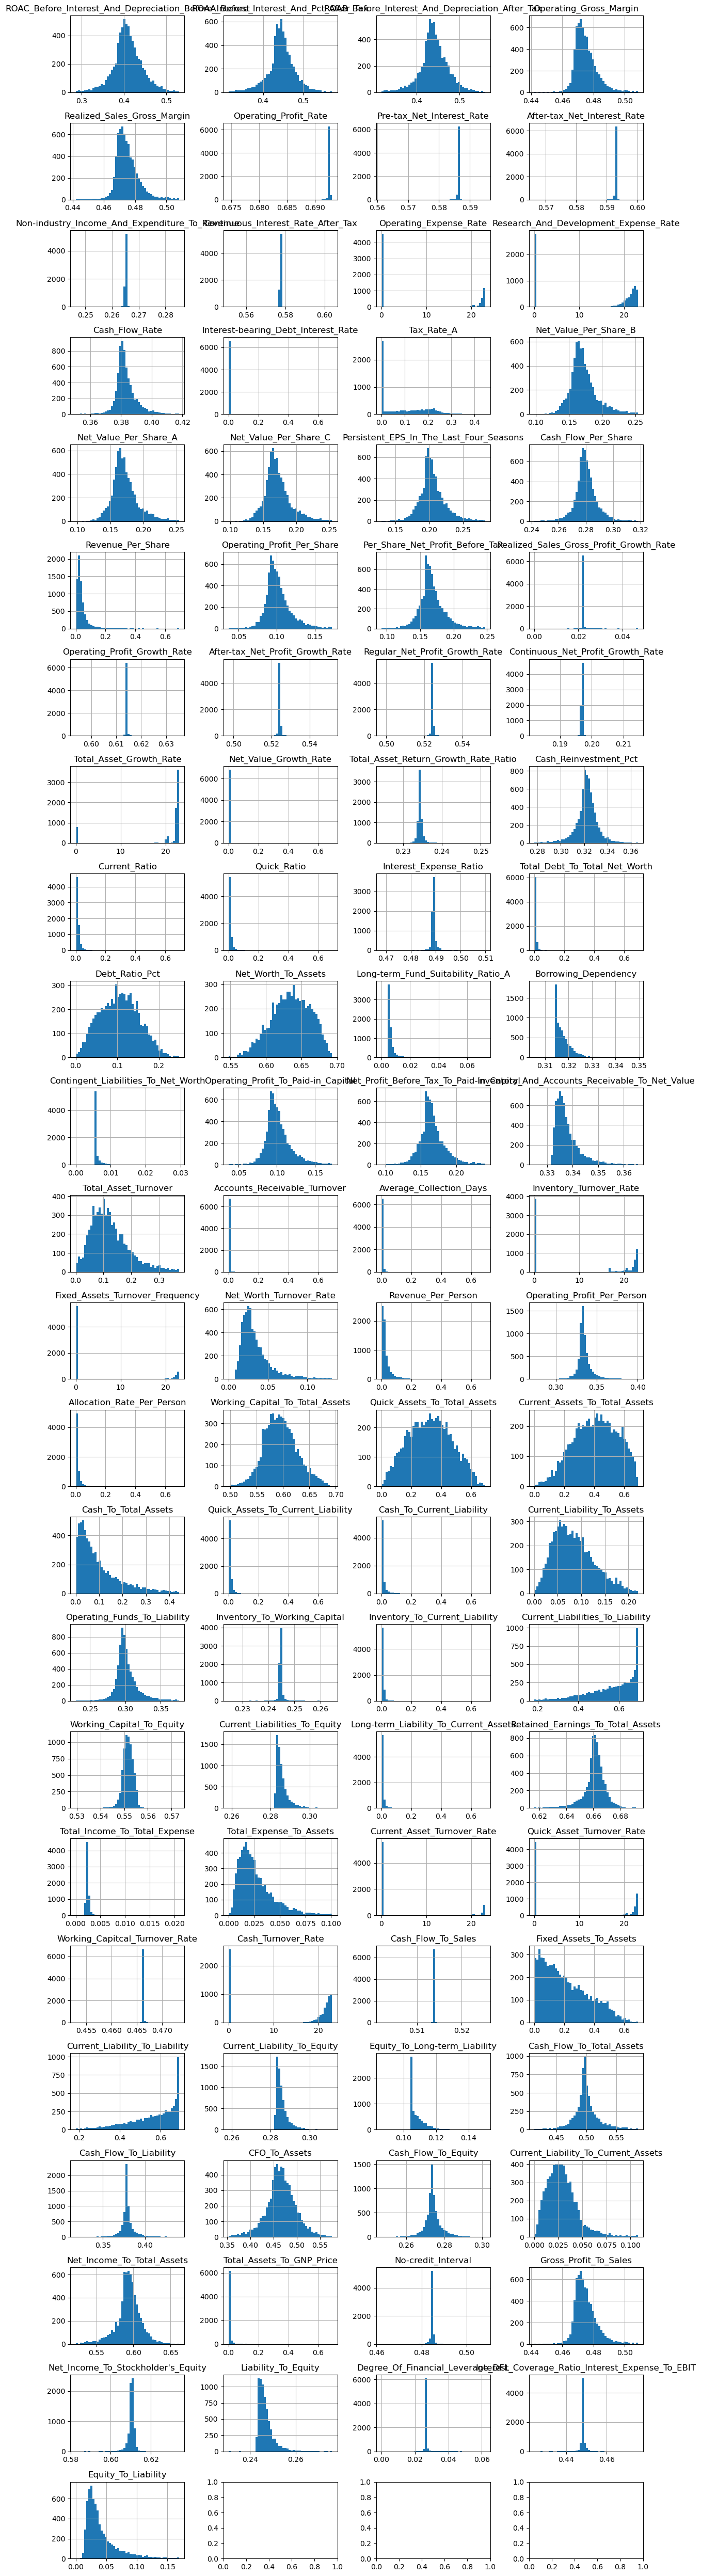

In [7]:
#___________ Check out the distribution of df without outliers

# numeric df without outliers
df_numeric_nonoutlier = df_nonoutlier.select_dtypes(include=[np.number])

# Create the figure and axes
fig, axes = plt.subplots(nrows=24, ncols=4, figsize=(12, 50))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each variable's histogram
for i, col in enumerate(df_numeric_nonoutlier.columns):
    df_numeric_nonoutlier[col].hist(ax=axes[i], bins=50)
    axes[i].set_title(col)

# Adjust layout
plt.tight_layout()

plt.show()


After removing outliers, there was an improvement in the distributions of the features. Now, let's examine the proportion of values identified as outliers for each feature.

Number of rows with at least one missing value: 1730


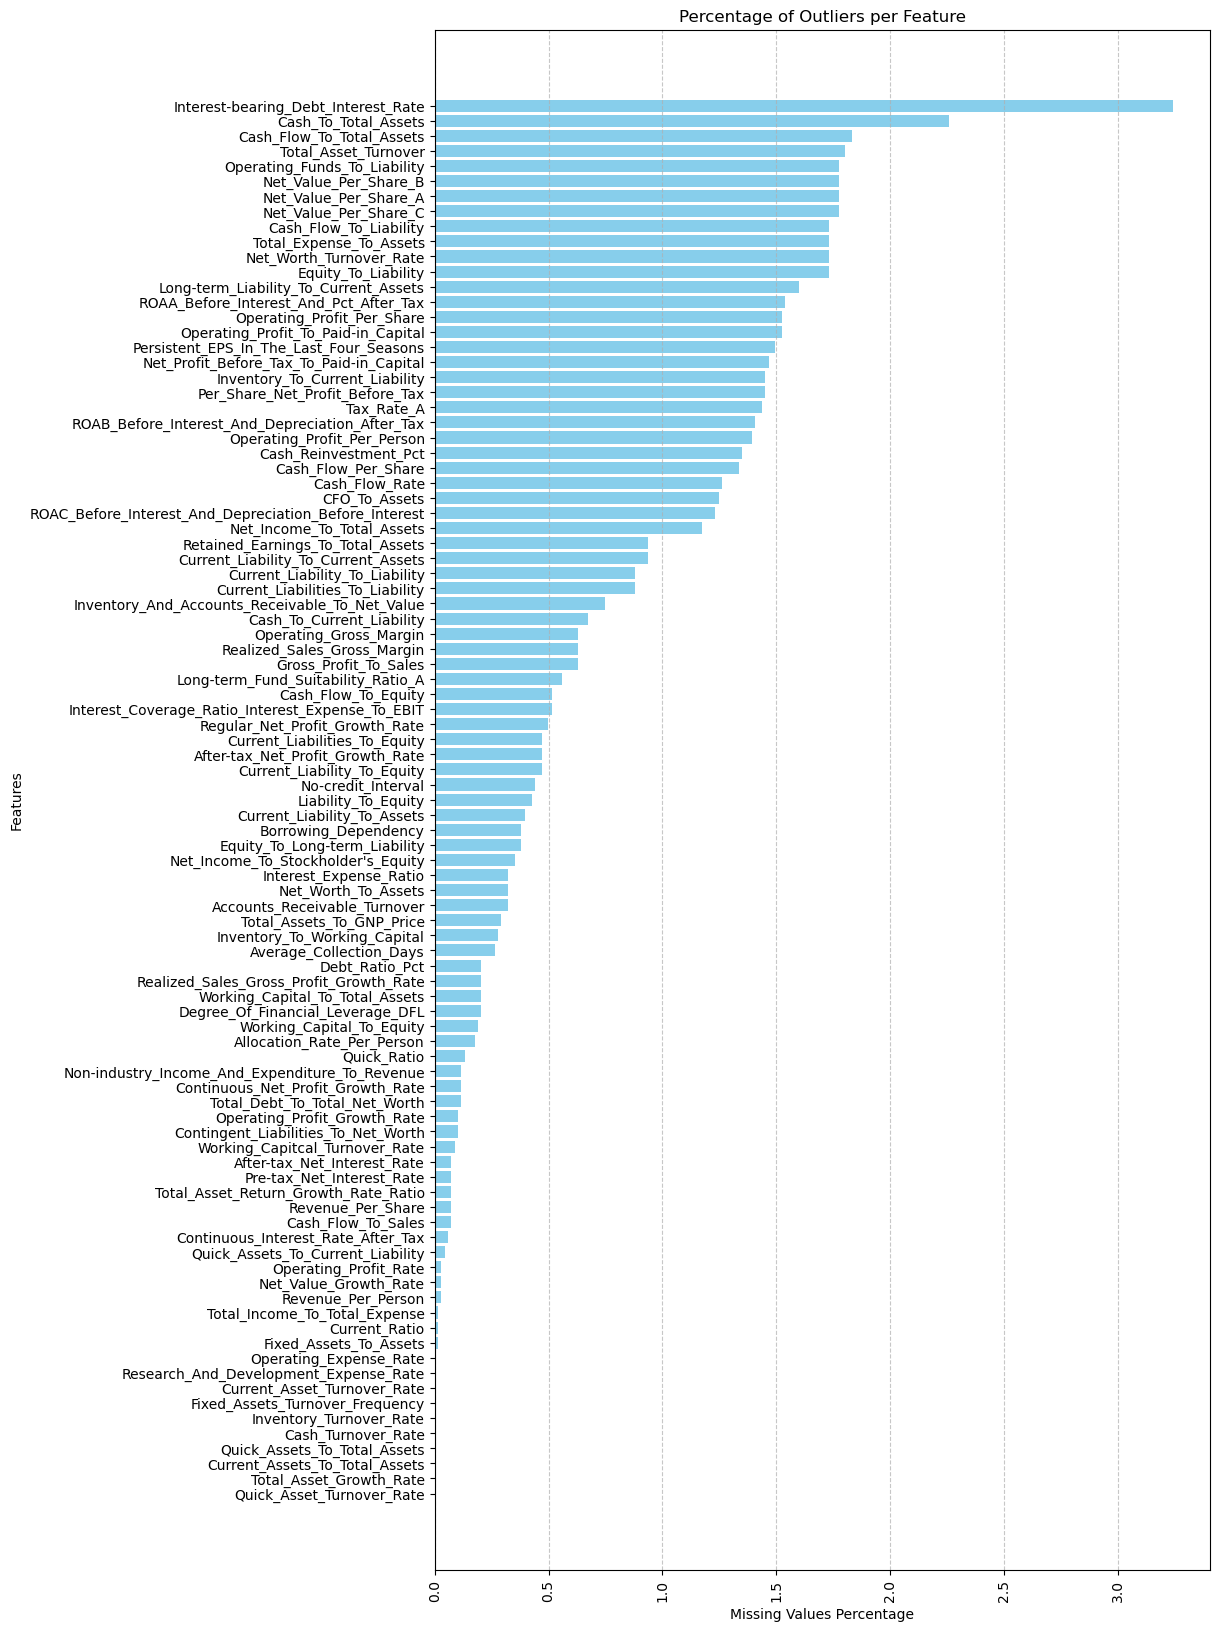

In [8]:
# Calculate missing value percentage per column
missing_percentage_per_column = (df_numeric_nonoutlier.isnull().sum() / len(df_numeric_nonoutlier)) * 100

# Sort the missing percentage values in ascending order
missing_percentage_per_column_sorted = missing_percentage_per_column.sort_values()

# Plot the bar plot
plt.figure(figsize=(10, 20))
plt.barh(missing_percentage_per_column_sorted.index, missing_percentage_per_column_sorted.values, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Missing Values Percentage')
plt.ylabel('Features')
plt.title('Percentage of Outliers per Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Count the number of rows with at least one missing value
rows_with_missing_values = df_numeric_nonoutlier.isnull().any(axis=1).sum()
print("Number of rows with at least one missing value:", rows_with_missing_values)

Using Z-scoring with a threshold level of 3.0 to replace outliers with NA results in all data having less than 3% missing values, as observed in the bar chart above. This indicates that replacing outliers with missing values yields a sufficiently low proportion for imputation.

### 2.1.3. Another Perspective on Outliers <a id='2.1.3_Another_Perspective_on_Outliers'></a>
<br>

Even if the proportion of outliers is low enough to consider replacing them with other values, it's important to think about whether outliers should be replaced. Sometimes, outliers may contain crucial information for predicting the target variable.

We are currently modeling an extreme event, namely corporate bankruptcy. Bankruptcy is more likely to occur when a company's financial ratios are extreme or considered outliers. Therefore, in the following section, I will examine the correlation between the features and the target variable, as well as the relationship between the outliers in the features and the target variable.

## 2.2 Bivariate Analysis

### 2.2.1 Relationship between the Features

First, let's examine the correlation between the features using heatmap.

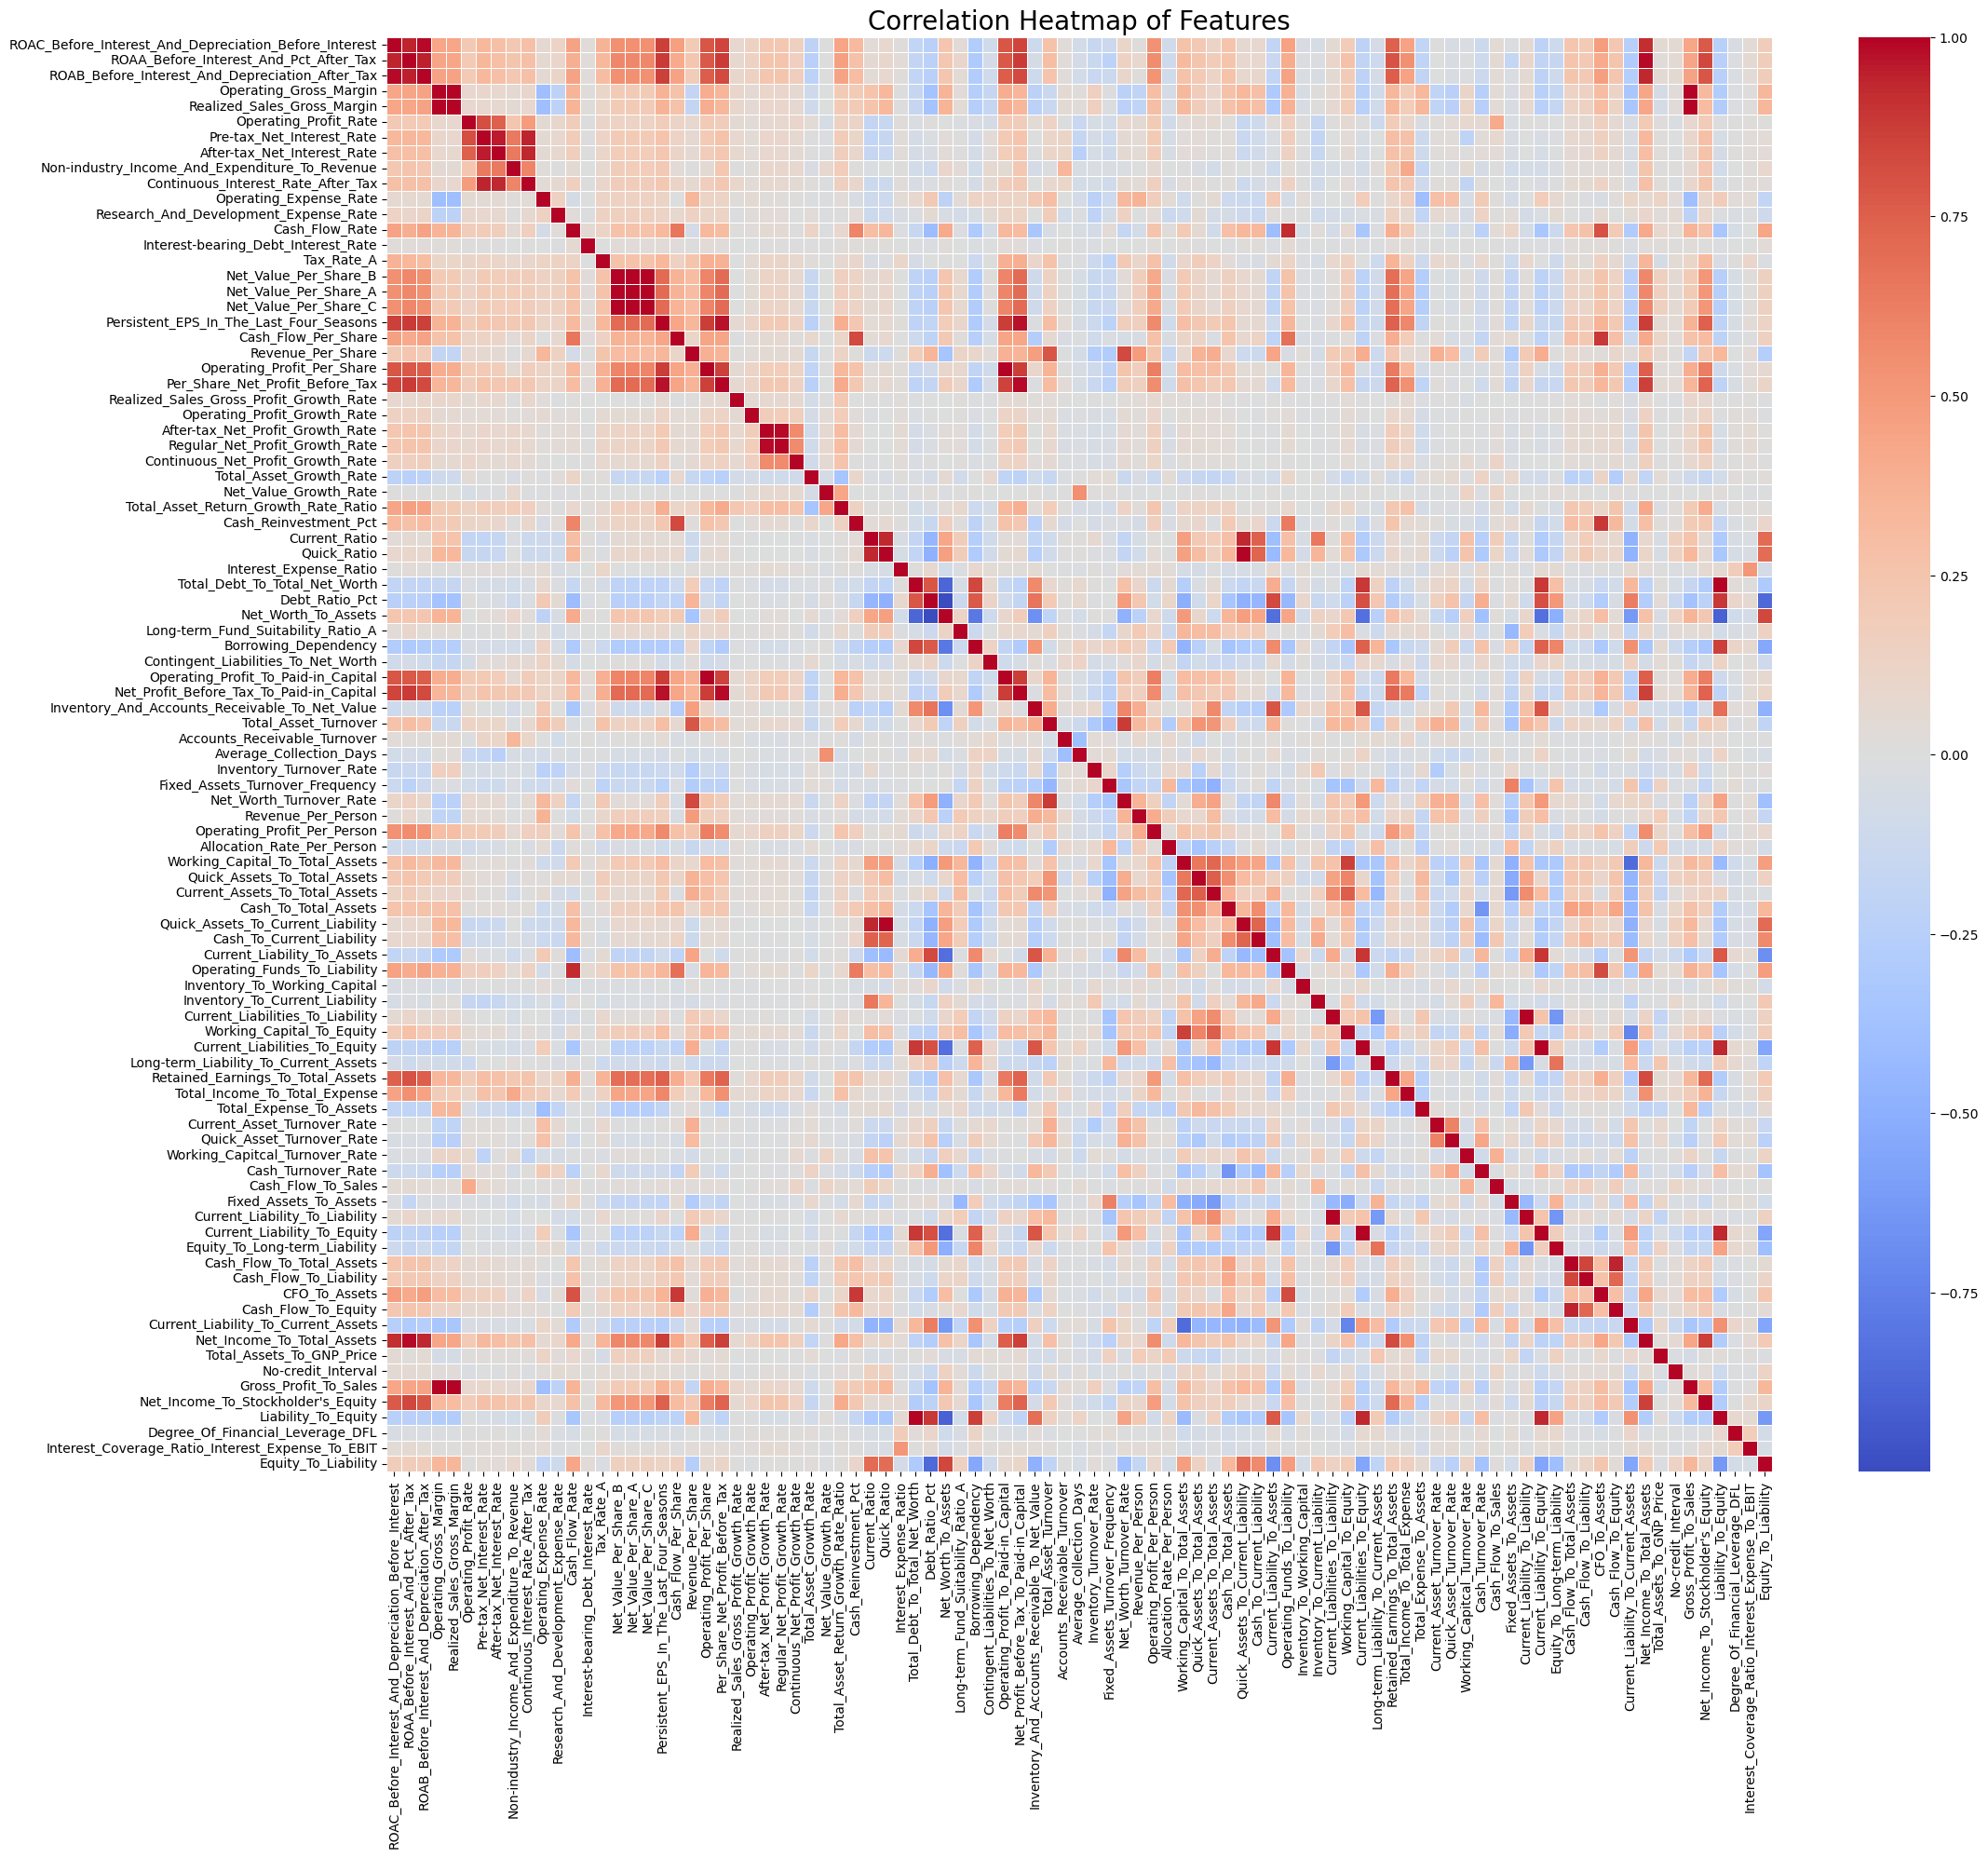

In [9]:
df_numeric = df.select_dtypes(include=[np.number])

correlation_matrix = df_numeric.corr()

# Set up the matplotlib figure
plt.figure(figsize=(24, 20))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Correlation Heatmap of Features', fontsize=20)

# Show the plot
plt.show()

The provided heatmap, representing a 93x93 matrix with thousands of values, visualizes the correlation coefficients between 93 features. While it's challenging to pinpoint the exact correlation values for specific pairs, it's evident that many pairs exhibit high absolute correlation coefficients. To figure out the number of pairs with correlation coefficients exceeding a certain threshold, I built the following function.

In [10]:
def high_corr_pairs(correlation_matrix, threshold=0.7):

    pairs = []
    correlations = []
    cols = correlation_matrix.columns
    
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) >= threshold:
                pairs.append((cols[i], cols[j]))
                correlations.append(corr_value)
    
    result_df = pd.DataFrame({
        'pairs': pairs,
        'correlation': correlations
    })
    
    result_df = result_df.sort_values(by='correlation', ascending=False).reset_index(drop=True)
    
    return result_df

In [11]:
high_corr_list = high_corr_pairs(correlation_matrix, threshold=0.7)
high_corr_list

pairs  correlation
0    (Current_Liabilities_To_Equity, Current_Liabil...     1.000000
1    (Current_Liabilities_To_Liability, Current_Lia...     1.000000
2      (Operating_Gross_Margin, Gross_Profit_To_Sales)     1.000000
3       (Net_Value_Per_Share_A, Net_Value_Per_Share_C)     0.999689
4       (Net_Value_Per_Share_B, Net_Value_Per_Share_A)     0.999440
..                                                 ...          ...
126  (Working_Capital_To_Total_Assets, Current_Liab...    -0.857757
127              (Debt_Ratio_Pct, Equity_To_Liability)    -0.861098
128  (Total_Debt_To_Total_Net_Worth, Net_Worth_To_A...    -0.875146
129         (Net_Worth_To_Assets, Liability_To_Equity)    -0.904568
130              (Debt_Ratio_Pct, Net_Worth_To_Assets)    -0.999035

[131 rows x 2 columns]

In the above table, we can find that 131 pairs of the features have correlation above 0.7 in absolute value. The reason for high absolute correlation values in the dataset is that these features are highly linearly related to each other. This often happens when features are derived from similar underlying metrics or when they represent the same concept in different ways. <br>

This suggests that there may be multicollinearity issues during subsequent modeling steps. Since there are many variables and multicollinearity issues, we may be able to solve this using PCA. We will discuss this in the modeling section.

### 2.2.2 Relationship between the Features and Target Variables

#### 2.2.2.1 Target vs Numerical Features <br>


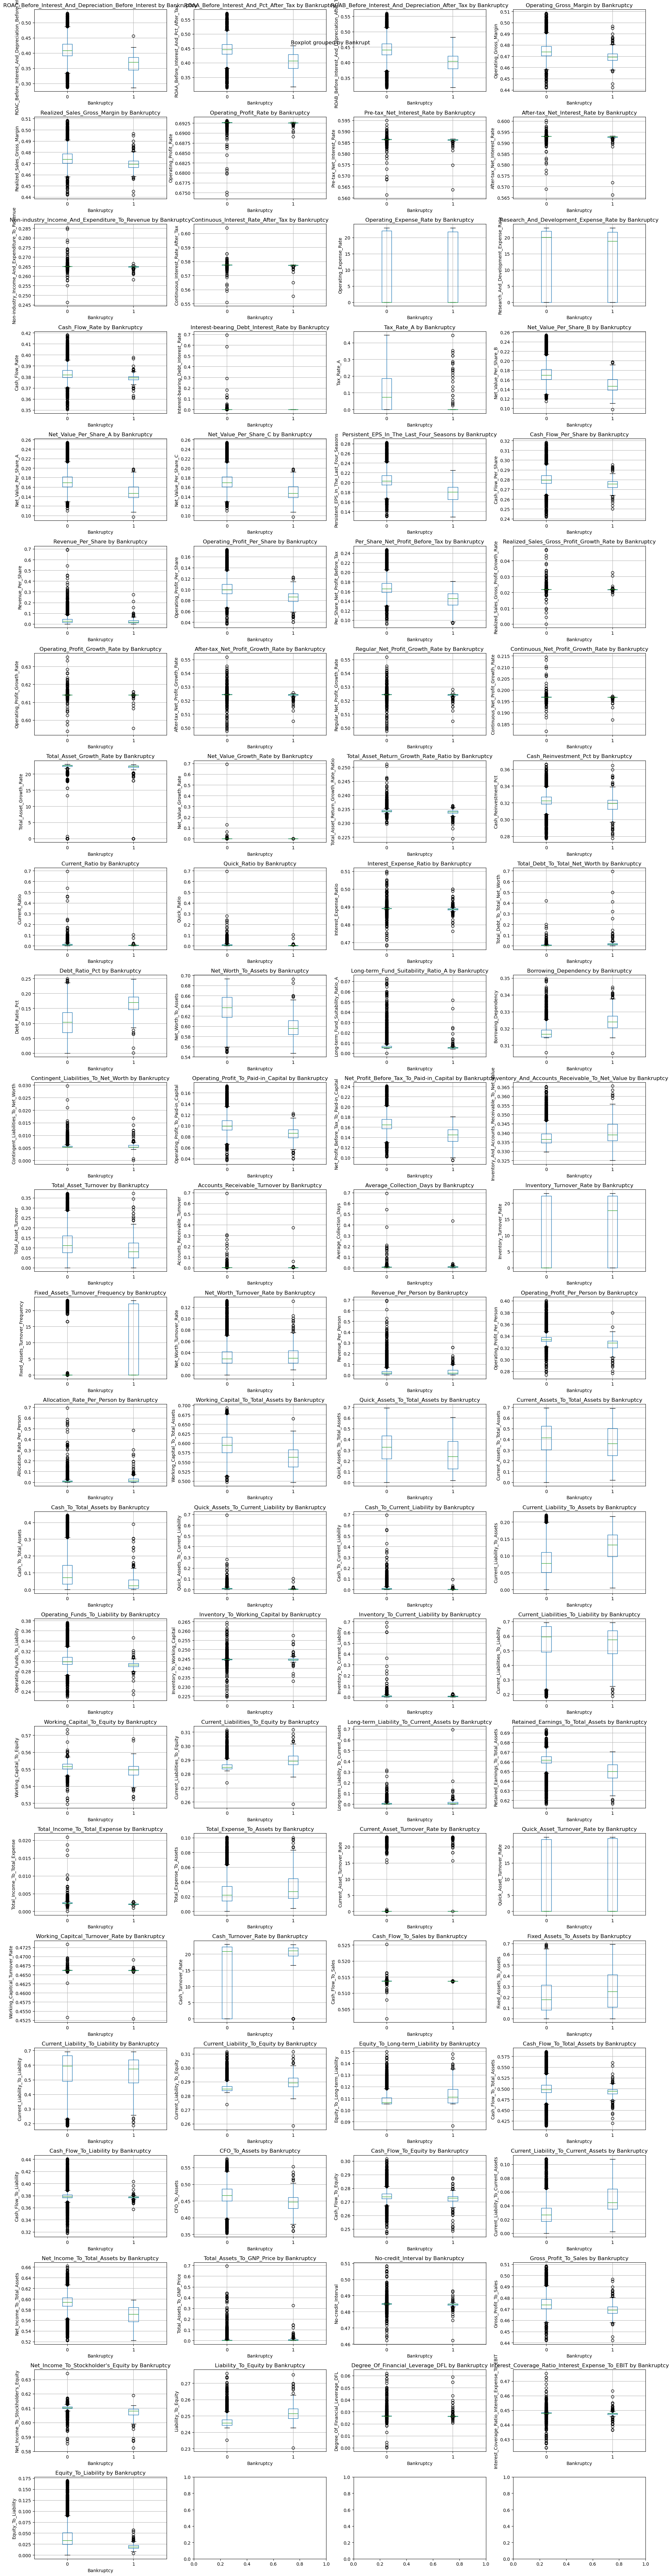

In [12]:
# retrieve the names of numerical features as list
numeric_features = df_nonoutlier.select_dtypes(include='number').columns.tolist()

# Create the figure and axes
fig, axs = plt.subplots(nrows=24, ncols=4, figsize=(20, 80))

# kde plots
for i, feature in enumerate(numeric_features):
    row = i // 4
    col = i % 4
    df_nonoutlier.boxplot(column=feature, by='Bankrupt', ax=axs[row, col])
    axs[row, col].set_title(f'{feature} by Bankruptcy')
    axs[row, col].set_xlabel('Bankruptcy')
    axs[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()

If the distribution characteristics of a feature differ according to the target variable value, that feature can be considered useful for prediction. Looking at the box plots above, variables included in the three categories of profitability, profit, growth, and financial stability are likely to be useful for bankruptcy prediction. <br>

* Profitability: ROA related features, Operating Gross Margin, Sales Gross Margin, etc.
* Profit: EPS, Operating Profit, Net Profit, Cash Flow, etc.
* Growth: Operating Profit Growth, Net Profit Growth Rate, etc.
* Stability: Current Ratio, Quick Ratio, Debt Ratio, Net Worth to Asset, etc.

#### 2.2.2.2 Target vs Outliers <br>

When the target variable is an extreme event, outliers in numerical features can play an important role in prediction. In particular, these outliers can better reflect extreme situations, helping the prediction model to detect such events more effectively. 

Using the following code, we will divide each numerical feature into outlier and normal groups, then calculate the proportion of the target variable being 1 for each group, and visualize it using a bar chart.

In [13]:
def calculate_bankrupt_proportions(data, target_col='Bankrupt'):
    
    # Convert the target column to integer
    data[target_col] = data[target_col].astype(int)
    
    proportions = {}

    # Get all numeric columns excluding the target column
    numeric_cols = data.select_dtypes(include=[np.number]).columns

    if target_col in numeric_cols:
        numeric_cols = numeric_cols.drop(target_col)

    for col in numeric_cols:
        # Handle missing values separately
        outliers = data[data[col].isna()]
        non_outliers = data[data[col].notna()]

        # Calculate proportions of bankruptcies in outliers and non-outliers
        prop_outliers = outliers[target_col].mean() if not outliers.empty else 0
        prop_non_outliers = non_outliers[target_col].mean() if not non_outliers.empty else 0

        proportions[col] = (prop_outliers, prop_non_outliers)

    return proportions

proportions = pd.DataFrame(calculate_bankrupt_proportions(df_nonoutlier))
proportions.index = ['Outlier', 'NonOutlier']
proportions

ROAC_Before_Interest_And_Depreciation_Before_Interest  \
Outlier                                              0.285714       
NonOutlier                                           0.029102       

            ROAA_Before_Interest_And_Pct_After_Tax  \
Outlier                                   0.304762   
NonOutlier                                0.028001   

            ROAB_Before_Interest_And_Depreciation_After_Tax  \
Outlier                                            0.302083   
NonOutlier                                         0.028410   

            Operating_Gross_Margin  Realized_Sales_Gross_Margin  \
Outlier                   0.139535                     0.139535   
NonOutlier                0.031582                     0.031582   

            Operating_Profit_Rate  Pre-tax_Net_Interest_Rate  \
Outlier                  0.000000                   0.000000   
NonOutlier               0.032272                   0.032286   

            After-tax_Net_Interest_Rate  \
Outlier                        0.000000   
NonOutlier                     0.032286   

            Non-industry_Income_And_Expenditure_To_Revenue  \
Outlier                                           0.250000   
NonOutlier                                        0.032007   

            Continuous_Interest_Rate_After_Tax  ...  \
Outlier                               0.000000  ...   
NonOutlier                            0.032282  ...   

            Current_Liability_To_Current_Assets  Net_Income_To_Total_Assets  \
Outlier                                  0.2500                    0.400000   
NonOutlier                               0.0302                    0.027897   

            Total_Assets_To_GNP_Price  No-credit_Interval  \
Outlier                      0.150000            0.066667   
NonOutlier                   0.031916            0.032111   

            Gross_Profit_To_Sales  Net_Income_To_Stockholder's_Equity  \
Outlier                  0.139535                            0.708333   
NonOutlier               0.031582                            0.029875   

            Liability_To_Equity  Degree_Of_Financial_Leverage_DFL  \
Outlier                0.517241                          0.071429   
NonOutlier             0.030191                          0.032182   

            Interest_Coverage_Ratio_Interest_Expense_To_EBIT  \
Outlier                                             0.028571   
NonOutlier                                          0.032282   

            Equity_To_Liability  
Outlier                0.016949  
NonOutlier             0.032532  

[2 rows x 93 columns]

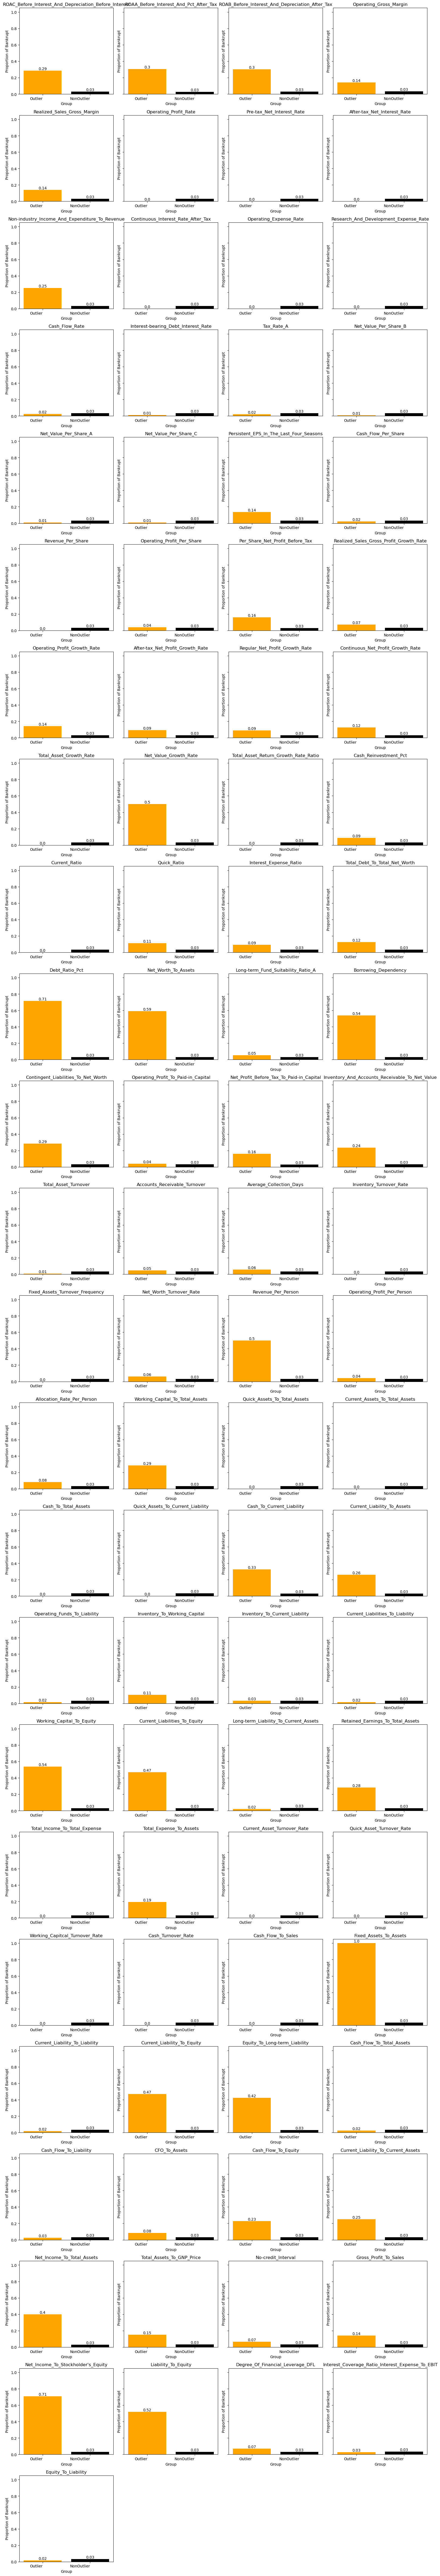

In [14]:
num_features = len(proportions.columns)
num_plots_per_row = 4
num_rows = int(np.ceil(num_features / num_plots_per_row))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_plots_per_row, figsize=(16, 4*num_rows), sharey=True)

# Flatten axes if there's only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, col in enumerate(proportions.columns):
    row_idx = idx // num_plots_per_row
    col_idx = idx % num_plots_per_row
    ax = axes[row_idx, col_idx]
    
    # Bar colors
    colors = ['orange' if label == 'Outlier' else 'black' for label in proportions.index]
    
    bars = ax.bar(proportions.index, proportions[col], color=colors)
    
    # Display data values on top of bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    
    ax.set_xlabel('Group')
    ax.set_ylabel('Proportion of Bankrupt')
    ax.set_title(col)
    ax.set_xticks(proportions.index)
    ax.set_xticklabels(proportions.index, ha='right')

# Hide unused axes
for i in range(num_features, num_rows * num_plots_per_row):
    axes.flatten()[i].axis('off')

fig.tight_layout()
plt.show()

In many numerical features, __there is a significant difference in bankruptcy rates between outliers and non-outliers__. This suggests that replacing outliers with different values may not be a good strategy. Therefore, __we will refrain from replacing outliers with different values in future analyses__.

#### 2.2.2.4 Target vs Categorical Feature

We have a categorical feature in our dataset called 'Liability-Assets_Flag', which is 1 if Total Liability exceeds Total Assets and 0 otherwise. Let's explore the relationship between this variable and the target variable.

In [15]:
contingency_table = pd.crosstab(df['Liability-Assets_Flag'], df['Bankrupt'])
contingency_table

Bankrupt                  0    1
Liability-Assets_Flag           
0                      6597  214
1                         2    6

Negative Equity, i.e., cases where Liability-Assets_Flag is 1, is a very rare event among companies. As seen in the contingency table above, out of 6819 data points, occurrences of this event are fewer than 8 instances. However, in these cases, the number of bankruptcies is 6, indicating that 75% of instances of negative equity resulted in bankruptcy. Thus, this feature would play a crucial role when we build models to predict the target variable.